In [5]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [15, 7]
import seaborn as sns

In [6]:
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme

In [1]:
import cv2
from glob import glob
import torch

with open('./WIDER/wider_face_train_bbx_gt.txt', 'r') as file:
    lines = file.readlines()

image_paths = []
n_objects = []

img_index = line_index = 0
bboxes_dict = {}

while line_index < len(lines):
    image_path = lines[line_index].strip()
    line_index += 1

    objects_line = lines[line_index].strip()
    num_objects = int(objects_line)
    line_index += 1
    
    objects = []
    truth = []
    if num_objects == 0:
        object_info = lines[line_index].strip().split(' ')
        object_info = [int(i)for i in object_info]
        truth.append(object_info)
        line_index += 1
    else:
        for _ in range(num_objects):
            object_coordinates = lines[line_index].strip().split(' ')
            object_coordinates = [int(object_coordinates[i]) for i in range(4)]
            object_coordinates[2] = object_coordinates[2] + object_coordinates[0]
            object_coordinates[3] = object_coordinates[3] + object_coordinates[1]
            truth.append(object_coordinates)
            line_index += 1
    
    img_index += 1
    
    bboxes_dict[img_index] = truth
    image_paths.append(image_path)
    n_objects.append(num_objects)
    
for i in range(3):
    print(f'{i + 1}: {bboxes_dict[i + 1]}')

1: [[449, 330, 571, 479]]
2: [[361, 98, 624, 437]]
3: [[78, 221, 85, 229], [78, 238, 92, 255], [113, 212, 124, 227], [134, 260, 149, 275], [163, 250, 177, 267], [201, 218, 211, 230], [182, 266, 197, 283], [245, 279, 263, 294], [304, 265, 320, 282], [328, 295, 344, 315], [389, 281, 406, 300], [406, 293, 427, 314], [436, 290, 458, 307], [522, 328, 543, 346], [643, 320, 666, 342], [653, 224, 670, 249], [793, 337, 816, 367], [535, 311, 551, 328], [29, 220, 40, 235], [3, 232, 14, 247], [20, 215, 32, 231]]


In [176]:
def scale_bbox(bbox, image, o_shape):
    W, H, C = o_shape
    w, h, c = image.shape
    Wratio = w/W
    Hratio = h/H
    ratioList = [Hratio, Wratio, Hratio, Wratio]
    bbox = [int(a * b) for a, b in zip(bbox, ratioList)]
    return bbox

# Function that returns redefined bbox
def function(image, bboxs, base=512):
    H, W, C = image.shape
    if H > W:
        height_persentage = float(base/H)
        width_size = int(W*height_persentage)
        resized_image = cv2.resize(image, (width_size, base), interpolation=cv2.INTER_CUBIC)
        h, w, c = resized_image.shape
        bbox = scale_bbox(bboxs, resized_image, (H, W, C))
        width1 = (base - w) // 2
        width2 = (base - w) - width1
        bbox = [bbox[0]+width1, bbox[1], bbox[2]+width2, bbox[3]]
        
        # Symmetric Padding
        mask = np.array(np.zeros(shape=(base, width1, C)), dtype=int)
        resized_image = np.concatenate((resized_image, mask), axis=1)

        mask = np.array(np.zeros(shape=(base, width2, C)), dtype=int)
        resized_image = np.concatenate((mask, resized_image), axis=1)
        # display(resized_image, bbox)
        
    else:
        width_percentage = float(base/W)
        height_size = int(H*width_percentage)
        resized_image = cv2.resize(image, (base, height_size), interpolation=cv2.INTER_CUBIC)
        h, w, c = resized_image.shape
        bbox = scale_bbox(bboxs, resized_image, (H, W, C))
        height1 = (base - h) // 2
        height2 = (base - h) - height1
        bbox = [bbox[0], bbox[1]+height1, bbox[2], bbox[3]+height2]
        
        # Symmetric Padding
        mask = np.array(np.zeros(shape=(height1, base, C)), dtype=int)
        resized_image = np.concatenate((resized_image, mask))
        
        mask = np.array(np.zeros(shape=(height2, base, C)), dtype=int)
        resized_image = np.concatenate((mask, resized_image))
        # display(resized_image, bbox)
    
    return bbox

In [180]:
import tqdm
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
redefined_bboxes = []

for idx in tqdm.trange(len(image_paths)):
    image = np.array(Image.open('./WIDER/WIDER_train/' + image_paths[idx]).convert("RGB"))
    
    for value in bboxes_dict[idx + 1]:
        bbox = np.array(value[:4])
        bbox = function(image, bbox)
        redefined_bboxes.append(bbox)
            
redefined_bboxes = torch.tensor(redefined_bboxes, dtype=torch.float)

100%|██████████| 12880/12880 [12:56<00:00, 16.60it/s] 


In [181]:
redefined_bboxes.shape

torch.Size([159424, 4])

In [182]:
from torchvision.ops import box_iou
from sklearn.cluster import KMeans

def kmeans_sklearn(bboxes, k):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(bboxes)
    clusters = kmeans.cluster_centers_
    distances = kmeans.transform(bboxes)
    return clusters, distances

Text(0, 0.5, 'IoU score')

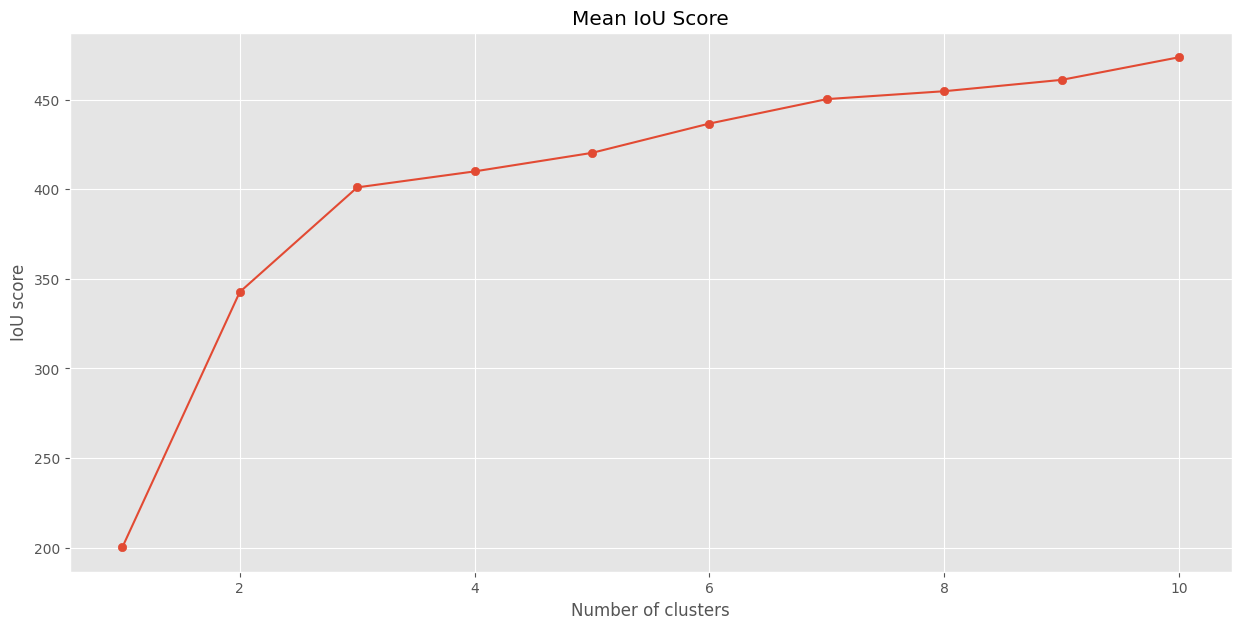

In [185]:
clusterList = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
mean_distances, anchorBoxes = [], []

for cluster_k in clusterList:
    redefined_bboxes = torch.tensor(redefined_bboxes, dtype=torch.float)
    anchors, distances = kmeans_sklearn(redefined_bboxes, k=cluster_k)
    distances = torch.tensor(distances)
    indxs = torch.argmax(distances, dim=1)
    filtered_distances = []
    for i, distance in enumerate(distances):
        filtered_distances.append(distance[indxs[i]].item())
    mean_distances.append(np.mean(filtered_distances))
    anchorBoxes.append(anchors)
    
plt.plot(clusterList, mean_distances)
plt.scatter(clusterList, mean_distances)
plt.title("Mean IoU Score")
plt.xlabel("Number of clusters")
plt.ylabel("IoU score")

In [186]:
anchors, distances = kmeans_sklearn(redefined_bboxes, k=10)

In [187]:
anchors

array([[333.10672154, 119.7851166 , 348.52119342, 140.03628258],
       [149.20741758, 223.09574685, 162.35286935, 240.18513431],
       [427.85801553, 314.13491579, 438.17820054, 327.5980452 ],
       [348.06686284, 232.90676257, 360.799248  , 249.43915863],
       [ 59.80412135, 158.04001145,  70.83531769, 172.62856325],
       [190.08694496, 111.50458655, 207.50279181, 134.30836214],
       [247.52186674, 200.31635848, 268.2633304 , 227.59343508],
       [ 64.32676098, 296.66715532,  74.29934765, 309.72711281],
       [448.09446717, 174.32333561, 459.0236878 , 188.91689389],
       [237.23686801, 329.78845638, 249.03642058, 344.7649217 ]])